In [1]:
import requests
from zipfile import ZipFile
from pathlib import Path

import os
import glob

import random as random
from PIL import Image

import torch
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from torchvision import datasets
from torchvision import transforms

import torchmetrics
import mlxtend

import matplotlib.pyplot as plt

from typing import Tuple
from typing import Dict
from typing import List
from timeit import default_timer as timer
from matplotlib import patches as mpatches

from tqdm.auto import tqdm

import gc

from numba import cuda

from GPUtil import showUtilization as gpu_usage

import splitfolders

from torchinfo import summary

import shutil

import numpy as np
import pandas as pd
import yaml

from os import listdir                  
from os.path import isfile, join

# 1. Training CNN to detect/recognize face emotions

## 1.1. Get the data

### Data Extraction from ZIP file

In [2]:
def extract_data(zipfile_path: Path, destination_path: Path) -> None:
    '''Extracts zipfile'''
    
    if destination_path.is_dir():
        print(f"{destination_path} exists.")
    else:
        print(f"{destination_path} doesn't exist, creating one...")
        destination_path.mkdir(parents=True, exist_ok=True)

    if not os.listdir(destination_path):
        with ZipFile(zipfile_path, 'r') as zip:
            print("Extracting files...")
            zip.extractall(destination_path)

            print("Extracting finished.")
    else:
        print("Data already extracted.")
    
data_path = Path("dataset")
zipfile_path = data_path / "emotion-detection-fer.zip"
images_path = data_path / "emotion-detection-fer"
print(zipfile_path, images_path)
extract_data(zipfile_path, images_path)


dataset/emotion-detection-fer.zip dataset/emotion-detection-fer
dataset/emotion-detection-fer exists.
Data already extracted.


## print_random_image prints one randomly chosen image from the whole dataset

Random image path: dataset/emotion-detection-fer/train/happy/im915.png
Random image class: happy
Image height: 48
Image width: 48


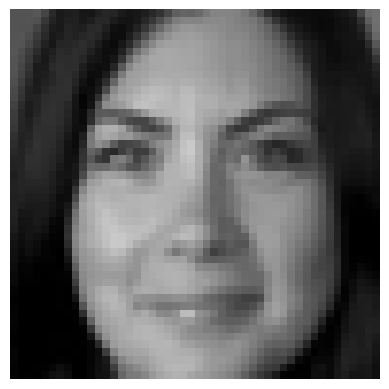

In [3]:
%matplotlib inline
import random
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

def print_random_image(images_path: list, seed=None) -> None:
    """Prints one random photo with details such as class, height, width"""
    if seed:
        random.seed(seed)

    random_image_path = random.choice(images_path)
    image_class = random_image_path.parent.stem
    image = Image.open(random_image_path)
    print(f"Random image path: {random_image_path}")
    print(f"Random image class: {image_class}")
    print(f"Image height: {image.height}")
    print(f"Image width: {image.width}")
    plt.imshow(image.convert('RGB'))
    plt.axis('off')  # Optionally turn off axis
    plt.show()

# Example usage:
images_path = Path('dataset/emotion-detection-fer')
image_path_list = list(images_path.glob("*/*/*"))  # Adjust glob pattern as per your directory structure
print_random_image(image_path_list)


## 1.2. Define transforms for train and validation data

### Plot the transformations for visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


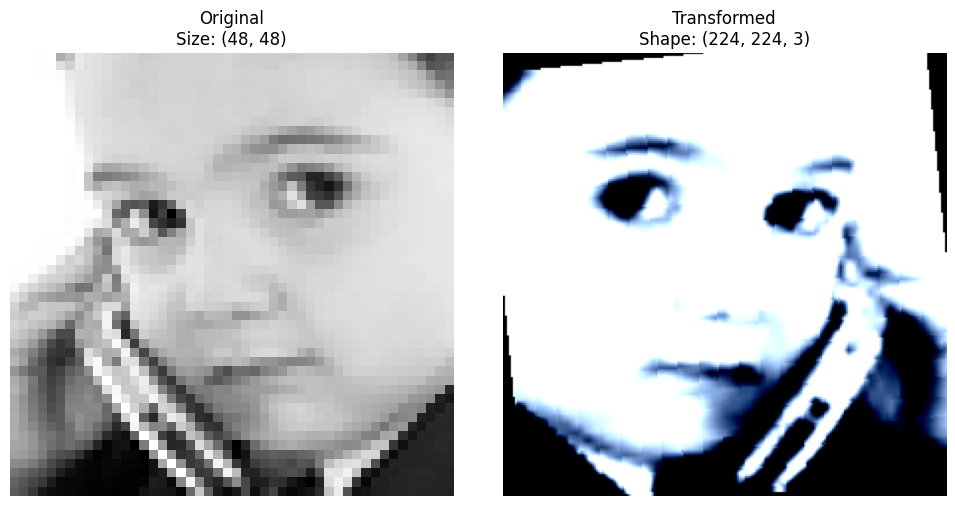

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].


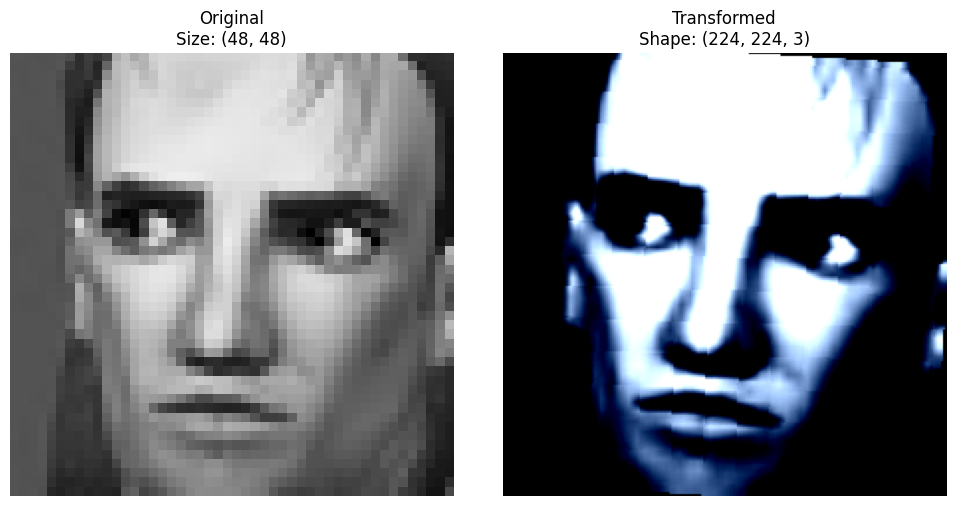

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


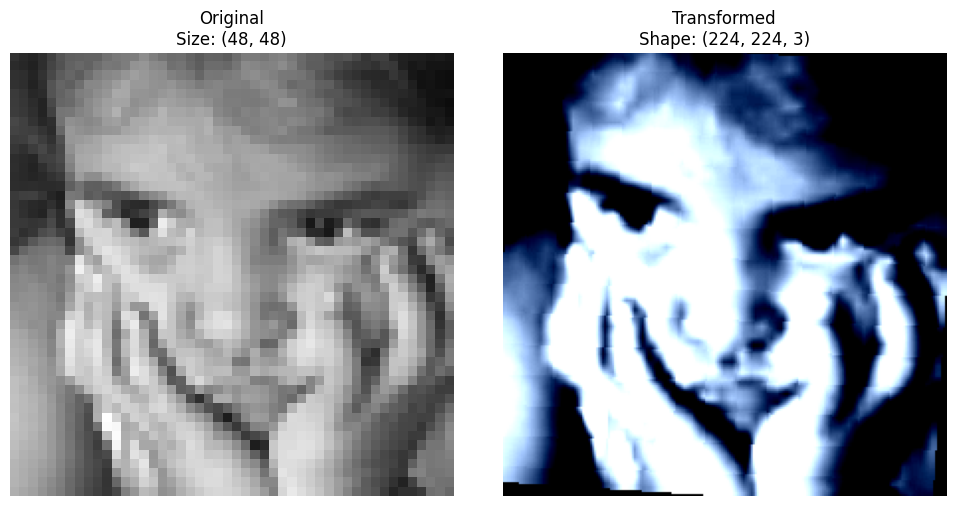

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import random
import torchvision.transforms as transforms
import torch

def plot_transformed_images(images_path: Path,
                            transform: transforms.Compose,
                            n: int=3,
                            seed=None) -> None:
    """Selects random images from a path, transforms them, and plots original vs transform"""
    if seed:
        random.seed(seed)

    if n > 10:
        print("n shouldn't be higher than 10 due to the size of displayed plot, changing n to 10")
        n = 10

    random_image_paths = random.sample(list(images_path.glob("*/*/*")), k=n)

    for image_path in random_image_paths:
        with Image.open(image_path).convert('RGB') as img:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            
            # Plot original image
            ax[0].imshow(img)
            ax[0].set_title(f"Original\nSize: {img.size}")
            ax[0].axis('off')
            
            # Apply transformation
            transformed_img = transform(img)
            
            # Convert transformed_img to numpy array and rearrange dimensions
            transformed_img = transformed_img.numpy().transpose(1, 2, 0)  # shape: (224, 224, 3)
            
            # Plot transformed image
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed\nShape: {transformed_img.shape}")
            ax[1].axis('off')
            
            plt.tight_layout()
            plt.show()

# Example usage:
image_path_list = Path('dataset/emotion-detection-fer')  # Adjust this to your image directory

# Define data augmentations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Define transformations for validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Example transformation, customize as needed
#     transforms.ToTensor()
# ])


# val_transform = transforms.Compose(
#     [transforms.Resize(size=(224, 224)),
#      transforms.ToTensor()]
# )

plot_transformed_images(image_path_list, train_transform)

## 1.3. Prepare the data
1) Save the data as two splits (train and val) that contain photos from train_dir and val_dir with applied transformations.
2) Set the dataloaders

In [10]:
images_path = Path('dataset/emotion-detection-fer')
train_dir = images_path / "train"
val_dir = images_path / "test"

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform
)

val_data = datasets.ImageFolder(
    root=val_dir,
    transform=val_transform
)

BATCH_SIZE = 16

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

## 1.5. Prepare the model
Define the weights and transforms and layers

Set the device.

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

# Define the CNN model
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Change 1 to 3 for RGB images
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjust the input size according to your image size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 7)  # 7 classes for 7 emotions
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Adjust the size according to your image size
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
# Define the improved CNN model
class ImprovedEmotionCNN(nn.Module):
    def __init__(self):
        super(ImprovedEmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))  # Adaptive pooling to 7x7 output size
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 7)  # 7 classes for 7 emotions

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.adaptive_pool(x)  # Apply adaptive pooling
        x = x.view(-1, 512 * 7 * 7)  # Flatten the output from the adaptive pooling layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device) -> Tuple[float, float, torch.Tensor]:

    model.eval()
    val_loss, val_acc = 0, 0
    y_preds = []


    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = torch.argmax(val_pred_logits, dim=1)
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))
            y_preds.append(val_pred_labels.cpu())

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    y_pred_tensor = torch.cat(y_preds)

    return val_loss, val_acc, y_pred_tensor


def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, epochs, device, patience, best_val_loss, epochs_no_improve):
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    print(patience, best_val_loss, epochs_no_improve)
    print(type(patience), type(best_val_loss), type(epochs_no_improve))
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        val_loss, val_acc, y_preds = val_step(model, val_dataloader, loss_fn, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_fn': loss_fn,
                'results': results,
                'preds': y_preds
            }
            torch.save(checkpoint, 'emotion_model_CNN.pth')
        else:
            epochs_no_improve += 1
            if (epochs_no_improve > patience):
                print(f'Early stopping after epoch {epoch + 1}')
                break

        print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results, y_preds, best_val_loss, epochs_no_improve


# Run the Model

In [39]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

EPOCHS = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model = ImprovedEmotionCNN().to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.01
)
patience = 10  # Adjust as needed
best_val_loss = float('inf')
epochs_no_improve = 0

start_time = timer()

model_results, preds, best_val_loss, epochs_no_improve = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device,
    patience=patience,  # Adjust as needed
    best_val_loss=best_val_loss,
    epochs_no_improve=0
    
)

end_time = timer()
print(f"Total learning time: {(end_time - start_time):.3f}")

Using device: cuda
10 inf 0
<class 'int'> <class 'float'> <class 'int'>


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, Train loss: 1.729, Train acc: 0.296, Val loss: 1.607, Val acc: 0.368
Epoch: 1, Train loss: 1.557, Train acc: 0.392, Val loss: 1.547, Val acc: 0.409
Epoch: 2, Train loss: 1.464, Train acc: 0.431, Val loss: 1.399, Val acc: 0.462
Epoch: 3, Train loss: 1.402, Train acc: 0.459, Val loss: 1.353, Val acc: 0.470
Epoch: 4, Train loss: 1.359, Train acc: 0.477, Val loss: 1.371, Val acc: 0.472
Epoch: 5, Train loss: 1.327, Train acc: 0.489, Val loss: 1.273, Val acc: 0.503
Epoch: 6, Train loss: 1.303, Train acc: 0.499, Val loss: 1.257, Val acc: 0.507
Epoch: 7, Train loss: 1.278, Train acc: 0.507, Val loss: 1.251, Val acc: 0.515
Epoch: 8, Train loss: 1.256, Train acc: 0.519, Val loss: 1.234, Val acc: 0.519
Epoch: 9, Train loss: 1.237, Train acc: 0.528, Val loss: 1.213, Val acc: 0.524
Epoch: 10, Train loss: 1.219, Train acc: 0.533, Val loss: 1.181, Val acc: 0.538
Epoch: 11, Train loss: 1.205, Train acc: 0.538, Val loss: 1.190, Val acc: 0.541
Epoch: 12, Train loss: 1.187, Train acc: 0.541, Va

## Load the Model Once trained OR Model already trained, Just LOAD IT!!!!

In [21]:
# Initialize the model
model = ImprovedEmotionCNN()

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the model state dictionary from the .pth file
checkpoint_path = "emotion_model_CNN.pth"
checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
y_preds = checkpoint['preds']
# Ensure the model is in evaluation mode
model.eval()
loss_fn = nn.CrossEntropyLoss()


print("Model and optimizer state loaded successfully.")
# val_loss, val_acc, y_preds = val_step(model, val_dataloader, loss_fn, device)

Model and optimizer state loaded successfully.


## Plot confusion Matrices & Visualize predictions

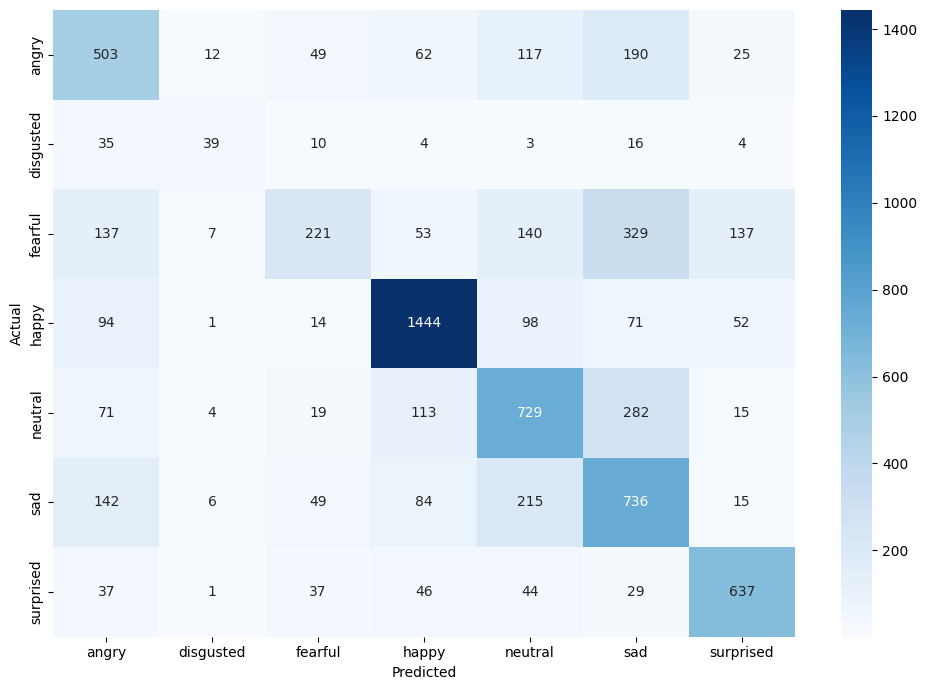

In [22]:
from torchmetrics.classification import ConfusionMatrix
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def draw_confusion_matrix(data: datasets.ImageFolder, preds: torch.Tensor) -> None:
    confmat = ConfusionMatrix(num_classes=len(data.classes), task="multiclass")
    confmat.update(preds, torch.ShortTensor(data.targets))
    confmat_tensor = confmat.compute()

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=data.classes,
        figsize=(10, 7)
    )
    plt.show()

def plot_confusion_matrix(conf_mat, class_names, figsize=(10, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()  # Ensures labels are not cut off
    return fig, ax  # Return the figure and axis objects

# Example usage:
# Ensure val_data and preds are properly defined
draw_confusion_matrix(data=val_data, preds=y_preds)


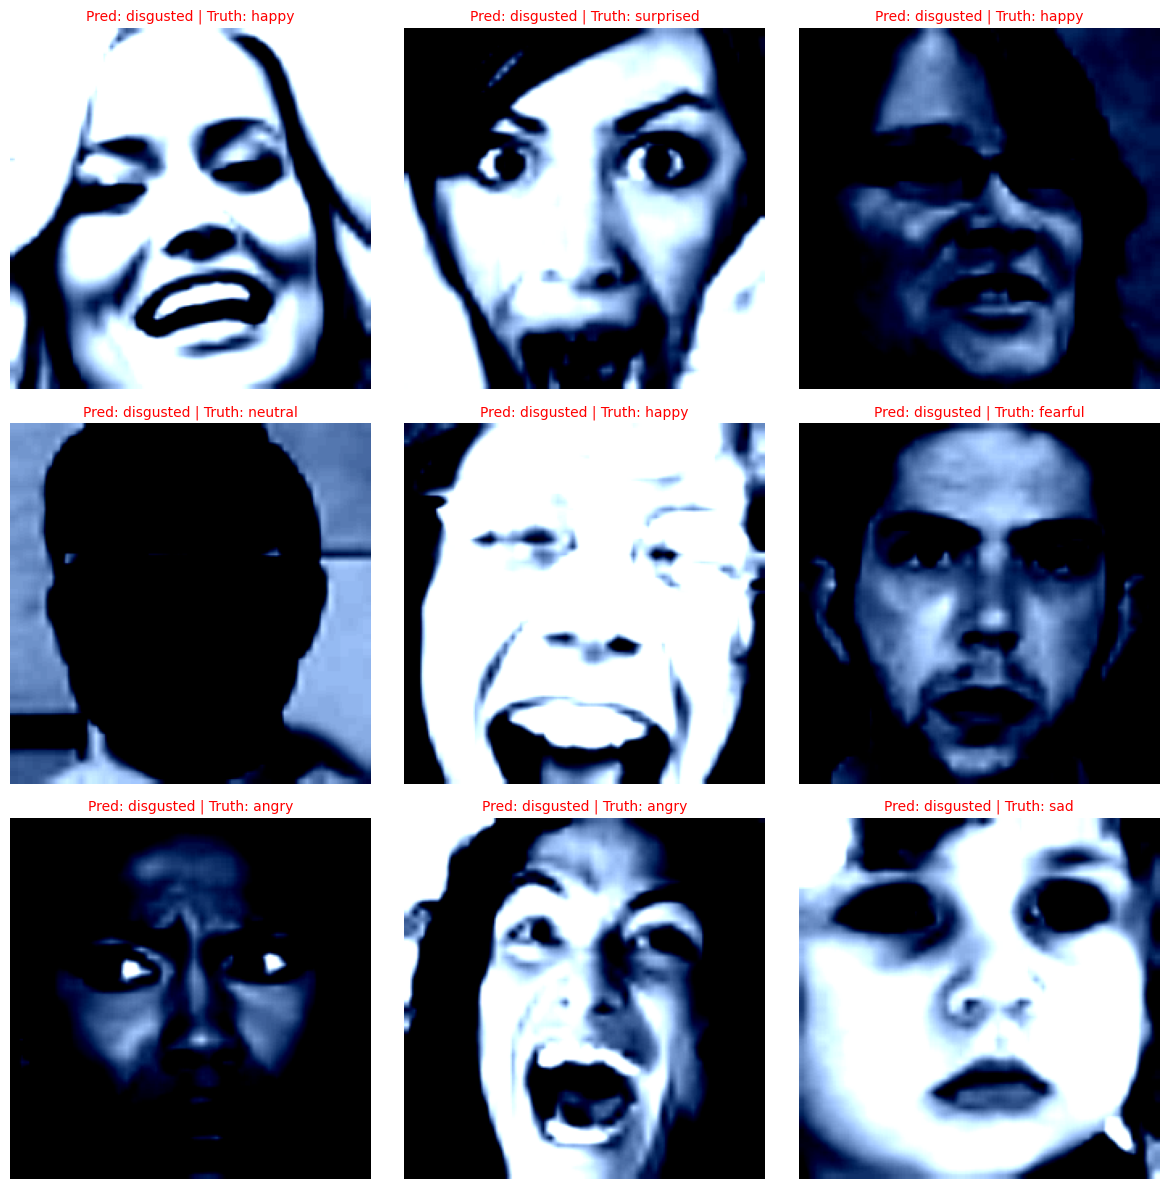

In [44]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device) -> torch.Tensor:

    pred_probs = []
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)



def show_predictions(model: torch.nn.Module,
                     val_data: datasets.ImageFolder,
                     device: torch.device) -> None:

    model.eval()

    # Get a random sample of 9 images from validation data
    indices = torch.randperm(len(val_data))[:9]
    val_samples = [val_data[i][0] for i in indices]
    val_labels = [val_data[i][1] for i in indices]

    pred_probs = make_predictions(
        model=model,
        data=val_samples,
        device=device
    )

    pred_classes = pred_probs.argmax(dim=1)
    plt.figure(figsize=(12, 12))
    nrows = 3
    ncols = 3

    for i, (sample, pred_label_idx, truth_label_idx) in enumerate(zip(val_samples, pred_classes, val_labels)):
        plt.subplot(nrows, ncols, i+1)
        image = sample.permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array
        image = np.clip(image, 0, 1)  # Clip to [0, 1] range if necessary
        plt.imshow(image)
        
        pred_label = val_data.classes[pred_label_idx]
        truth_label = val_data.classes[truth_label_idx]
        title_text = f"Pred: {pred_label} | Truth: {truth_label}"

        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, color="g")
        else:
            plt.title(title_text, fontsize=10, color="r")
        plt.axis(False)

    plt.tight_layout()
    plt.show()


# Example usage:
show_predictions(model=model, val_data=val_data, device=device)


# LOAD the trained YOLO model which you trained for face detection

In [ ]:
import torch
model_yolo = torch.hub.load('ultralytics/yolov5', 'custom', path = 'runs/train/exp17/weights/best.pt', force_reload=True)

## Real-Time face detection & emotion recognition

In [ ]:
import cv2
import tensorflow as tf
import requests
from zipfile import ZipFile
from pathlib import Path

import os
import glob

import random as random
from PIL import Image

import torch
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from torchvision import datasets
from torchvision import transforms

import torchmetrics
import mlxtend

import matplotlib.pyplot as plt

from typing import Tuple
from typing import Dict
from typing import List
from timeit import default_timer as timer
from matplotlib import patches as mpatches

from tqdm.auto import tqdm

import gc

from numba import cuda

from GPUtil import showUtilization as gpu_usage

import splitfolders

from torchinfo import summary

import shutil

import numpy as np
import pandas as pd
import yaml

from os import listdir                  
from os.path import isfile, join
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# video = "3249935-uhd_3840_2160_25fps.mp4"
cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture(video)

## Create transform for images detected by yolo
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

assert cap.isOpened()

## video loop
while(cap.isOpened()):
    ret, frame = cap.read()
    assert not isinstance(frame,type(None)), 'frame not found'
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)    
    results = model_yolo(frame)   
    print(results)
    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
    
    labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
    width, height = frame.shape[1], frame.shape[0]
    print(labels, coordinates)
    for i in range(0, len(labels)):
        row = coordinates[i]
        # if row[4] >= 0.1: ## if yolo detects face with prob > 0.4
        x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height) ## get x, y of the bbox
        face_crop = frame[int(y1):int(y2), int(x1):int(x2)] ## crop the face
        gray = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)
        roi_gray = cv2.resize(gray, (48, 48))
        roi_gray = roi_gray.astype('float32') / 255.0
        roi_gray = np.expand_dims(roi_gray, axis=0)
        roi_gray = np.expand_dims(roi_gray, axis=0)
        transformed_image = torch.from_numpy(roi_gray).float().to(device)
        # transformed_image = (test_transform(face_crop)).unsqueeze_(0) ## create the transform of cropped imgae
        model = model.to(torch.device(device)) ## send model to device 
        transformed_image = transformed_image.to(torch.device(device)) ## send data to device
        
        pred_label = torch.max(model(transformed_image), 1) ## get pred label
        pred_class = val_data.classes[pred_label.indices.item()] ## get pred class
        
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) ## create bbox rectangle
        cv2.putText(frame, f"{pred_class}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3) ## create bbox text
            
    cv2.imshow('YOLO', frame) ## show frame
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()